In [317]:
import numpy as np
import pandas as pd 
from scipy import linalg as LA
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler

## Data for testing

In [318]:
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)

In [319]:
features = df.columns[0:4] #grab all numeric columns of interest

In [320]:
features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


# PCA Implementation

## Satandardization

### Implementation

In [342]:
def standardize(df):
    df_copy = df.copy()
    
    for col in list(df_copy.columns):
        col_mean = df_copy[col].mean()
        col_std = df_copy[col].std()
        df_copy[col] = (df_copy[col] - col_mean) / (col_std)
    return df_copy

### Testing

#### Before standardization

In [343]:
df.mean()

sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
target               1.000000
dtype: float64

array([[<AxesSubplot:title={'center':'sepal length (cm)'}>,
        <AxesSubplot:title={'center':'sepal width (cm)'}>],
       [<AxesSubplot:title={'center':'petal length (cm)'}>,
        <AxesSubplot:title={'center':'petal width (cm)'}>]], dtype=object)

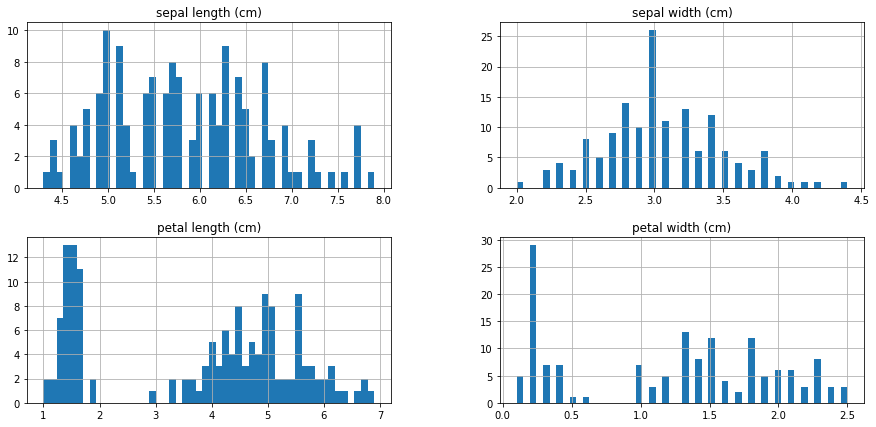

In [344]:
df[features].hist(bins = 50, figsize=(15,7))

#### After standardization

In [345]:
df_standard = pd.DataFrame(standardize(df[features]))

array([[<AxesSubplot:title={'center':'sepal length (cm)'}>,
        <AxesSubplot:title={'center':'sepal width (cm)'}>],
       [<AxesSubplot:title={'center':'petal length (cm)'}>,
        <AxesSubplot:title={'center':'petal width (cm)'}>]], dtype=object)

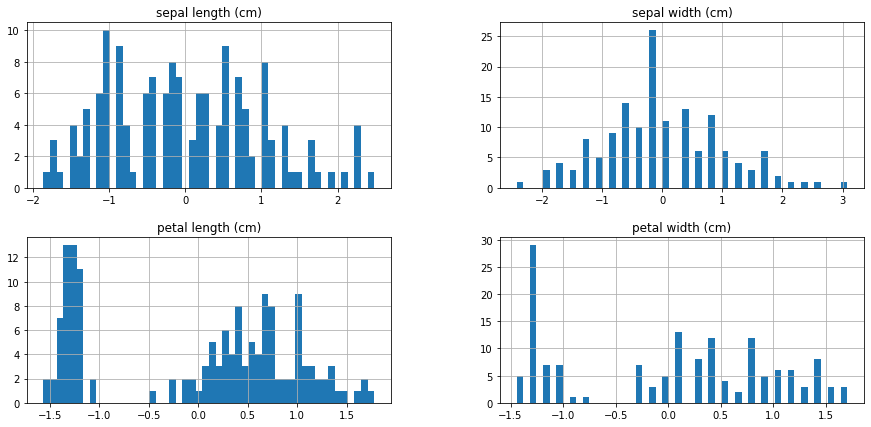

In [346]:
df_standard.hist(bins = 50, figsize=(15,7))

## Covariance Matrix Computation

### Implementation

In [347]:
def get_convariance_matrix(df):
    cov_mat = df.cov()
    return cov_mat

### Testing

##### Before standardization, variances are not 1

In [348]:
cov_matrix = get_convariance_matrix(df[features])
cov_matrix

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),0.685694,-0.042434,1.274315,0.516271
sepal width (cm),-0.042434,0.189979,-0.329656,-0.121639
petal length (cm),1.274315,-0.329656,3.116278,1.295609
petal width (cm),0.516271,-0.121639,1.295609,0.581006


##### After standardization, variances are 1

In [349]:
cov_matrix = get_convariance_matrix(df_standard)
cov_matrix

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


## Finding Eigenvalues and Eigenvectors

### Implementation

In [350]:
def get_eigenvectors(mat):
    eig_values, eig_vectors = np.linalg.eig(mat) 
    
    idx = eig_values.argsort()[::-1]   
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    
    info_in_dim = [float(eig/sum(eig_values))*100 for eig in eig_values]
    return eig_values, eig_vectors, info_in_dim

### Testing

In [351]:
eig_values, eig_vectors, info_in_dim = get_eigenvectors(cov_matrix)
print("Sorted eigenvalues are\n", eig_values, '\n\nSorted eigenvectors are\n', eig_vectors,
      "\n\nThe percentage of variance (information) accounted for by each component is\n", info_in_dim)

Sorted eigenvalues are
 [2.91849782 0.91403047 0.14675688 0.02071484] 

Sorted eigenvectors are
 [[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]] 

The percentage of variance (information) accounted for by each component is
 [72.96244541329987, 22.85076178670178, 3.668921889282873, 0.5178709107154614]


## Project the Data Along the Principal Component Axes

### Implementation

In [352]:
def project_data_on_pc(data, eig_vectors, ndim = 1):
    projected_df = pd.DataFrame({'PCA_0' : []})
    
    for i in range(ndim):
        col_name = "PCA_" + str(i)
        transformed_data = data.dot(eig_vectors.T[i])
        projected_df[col_name] = transformed_data
    return projected_df

### Testing

In [353]:
print(df_standard.shape, eig_vectors.shape)
print(project_data_on_pc(df_standard, eig_vectors, 2))  

(150, 4) (4, 4)
        PCA_0     PCA_1
0   -2.257141 -0.478424
1   -2.074013  0.671883
2   -2.356335  0.340766
3   -2.291707  0.595400
4   -2.381863 -0.644676
..        ...       ...
145  1.864258 -0.385674
146  1.559356  0.893693
147  1.516091 -0.268171
148  1.368204 -1.007878
149  0.957448  0.024250

[150 rows x 2 columns]


## Combining all the previous

### Implementation

In [360]:
class PCA: 
    def __init__(self, data):
        self.original_data = data
        self.standard_data = None
        self.info = []
        self.eig_values = []
        self.eig_vectors = []
    
    def standardize(self):
        df_copy = self.original_data.copy()

        for col in list(df_copy.columns):
            col_mean = df_copy[col].mean()
            col_std = df_copy[col].std()
            df_copy[col] = (df_copy[col] - col_mean) / (col_std)
        return df_copy
    
    def get_convariance_matrix(self, df):
        cov_mat = df.cov()
        return cov_mat
    
    def get_eigenvectors(self, mat):
        eig_values, eig_vectors = np.linalg.eig(mat) 

        idx = eig_values.argsort()[::-1]   
        eig_values = eig_values[idx]
        eig_vectors = eig_vectors[:,idx]

        info_in_dim = [float(eig/sum(eig_values))*100 for eig in eig_values]
        return eig_values, eig_vectors, info_in_dim
    
    def fit(self):
        self.standard_data = self.standardize()
        cov_matrix = self.get_convariance_matrix(self.standard_data)
        self.eig_values, self.eig_vectors, self.info_in_dim = self.get_eigenvectors(cov_matrix)
    
    def project(self, ndim = 1):
        projected_df = pd.DataFrame({'PCA_0' : []})
        try:
            for i in range(ndim):
                col_name = "PCA_" + str(i)
                transformed_data = self.standard_data.dot(self.eig_vectors.T[i])
                projected_df[col_name] = transformed_data
        except IndexError:
            print("Dimensions are greater than the eigen vectors, please reduce it")
        except:
            print("Check the inputs and try again") 
        return projected_df

    def get_percentage_of_variance(self):
        return self.info_in_dim

### Testing

In [361]:
pca = PCA(df[features]) 
pca.fit()
pca.get_percentage_of_variance()

[72.96244541329987, 22.85076178670178, 3.668921889282873, 0.5178709107154614]

Choosing the first two components only

In [363]:
transformed_df = pca.project(2)
transformed_df

,PCA_0,PCA_1
0,-2.257141,-0.478424
1,-2.074013,0.671883
2,-2.356335,0.340766
3,-2.291707,0.595400
4,-2.381863,-0.644676
...,...,...
145,1.864258,-0.385674
146,1.559356,0.893693
147,1.516091,-0.268171
148,1.368204,-1.007878


### Comparing with sklearn library

In [364]:
pca_lib = sklearn.decomposition.PCA(n_components=2)
pca_lib.fit(df_standard)

PCA(n_components=2)

In [365]:
transformed_df_lib = pd.DataFrame(pca_lib.transform(df_standard))
transformed_df_lib

,0,1
0,-2.257141,0.478424
1,-2.074013,-0.671883
2,-2.356335,-0.340766
3,-2.291707,-0.595400
4,-2.381863,0.644676
...,...,...
145,1.864258,0.385674
146,1.559356,-0.893693
147,1.516091,0.268171
148,1.368204,1.007878
